# Learning theory

In machine learning, in supervised learning our goal is often to learn a function $ f $ from input data $ X $ that can predict output (or label) $ Y $.  For instance, given a dataset of house sizes and their prices, we're trying to learn a function $ f $ such that:

$$ f(\text{house size}) = \text{house price} $$


Real-world data is rarely perfect. It often contains noise, which are the random fluctuations that can't be explained by the model. This noise can arise from various sources, such as measurement errors, non-representative samples, or inherent randomness in the system.
The total error in our predictions can be broken down into:

The prediction error of a model can be decomposed into two components:

1. **Reducible Error**: This is the error due to the model itself. By choosing a more appropriate model, tuning hyperparameters, or gathering more data, we can potentially reduce this error.

2. **Irreducible Error**: This represents the noise in the data. No matter how good our model is, we can't eliminate this error because it's a result of inherent randomness or other factors beyond our control.

Mathematically, the expected mean squared error (MSE) for predictions can be decomposed as:

$$ \text{E}[\text{MSE}] = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error} $$

Where:

- **Bias** is the error introduced by approximating the real-world problem (which may be complex) by a too-simple model.
- **Variance** is the error introduced by the model's complexity in trying to fit the data.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats import multivariate_normal

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, label_binarize
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


#### Demonstration:

Let's create a simple dataset based on a known function with some added noise. We'll then try to learn this function with a regression model to illustrate the concept of noise and error components.

We are going to generate data from a sine curve.

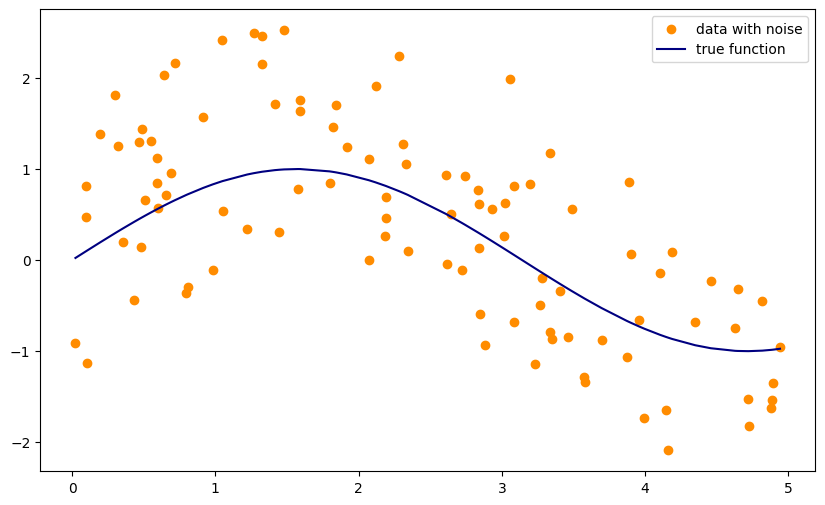

In [3]:
# Generate synthetic data
np.random.seed(0)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y_true = np.sin(X).ravel()
y = y_true + np.random.normal(0, 0.8, size=X.shape[0])  # Adding noise

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='darkorange', label='data with noise')
plt.plot(X, y_true, color='navy', label='true function')
plt.legend()
plt.show()


Let's try and fit some models, with different degrees of complexity. We will fit polynomial models with 1, 3, or 20 degrees.

Note our model assumption does not match our data generation.

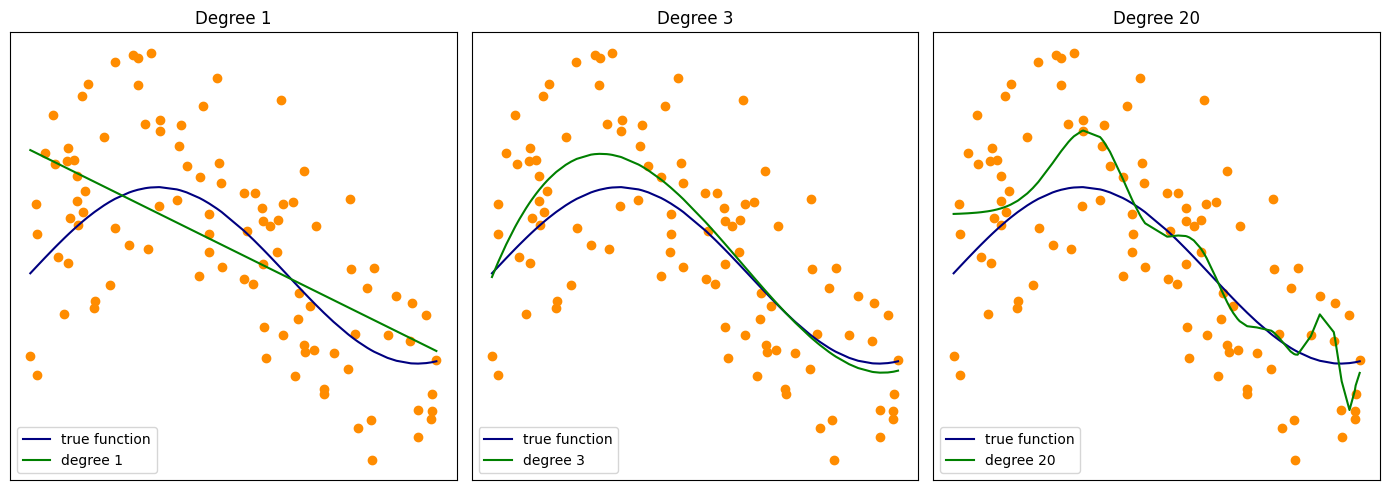

In [4]:
degrees = [1, 3, 20]
plt.figure(figsize=(14, 5))

for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polynomial.fit(X, y)
    y_pred = polynomial.predict(X)

    plt.scatter(X, y, color='darkorange')
    plt.plot(X, y_true, color='navy', label='true function')
    plt.plot(X, y_pred, color='green', label='degree %d' % degree)
    plt.legend(loc='lower left')
    plt.title(f"Degree {degree}")

plt.tight_layout()
plt.show()


Certainly. Let's compute the bias, variance, and irreducible error for each of the polynomial models we proposed earlier (degrees 1, 4, and 15).

To compute these, we'll follow these steps:

1. **Bias^2**:
   $$
   \text{Bias}^2(x) = \left( \text{E}[ \hat{f}(x) ] - f(x) \right)^2
   $$
   Here, \( \hat{f}(x) \) is the model prediction, and \( f(x) \) is the true function. The expectation is over different training sets.
   
2. **Variance**:
   $$
   \text{Var}(x) = \text{E}\left[ \left( \hat{f}(x) - \text{E}[ \hat{f}(x) ] \right)^2 \right]
   $$
   This measures how much the model predictions will vary for a given point \( x \) over different training sets.
   
3. **Irreducible Error**:
   Given by the noise in the data. If we assume the noise follows a Gaussian distribution, the irreducible error is its variance.
   
To estimate these values, we can use a bootstrap method: We'll sample the dataset with replacement multiple times, fit our models to these samples, and then compute the predictions. This will allow us to estimate the expected value and variance of the predictions.


In [5]:
results = {}
n_bootstrap = 1000
degrees = [1, 2, 3, 4, 5, 10, 20]

# Pre-allocate arrays large enough for any degree, then reuse them
n = len(X)
for d in degrees:
    # Online computation of mean and variance (Welford) to save memory
    mean_pred = np.zeros(n)
    m2_pred   = np.zeros(n)

    for b in range(1, n_bootstrap + 1):
        X_s, y_s = resample(X, y)
        model = make_pipeline(
            PolynomialFeatures(d, include_bias=False),
            LinearRegression()
            )
        model.fit(X_s, y_s)
        y_pred = model.predict(X)          # **in-sample** prediction

        delta = y_pred - mean_pred
        mean_pred += delta / b
        m2_pred   += delta * (y_pred - mean_pred)

    var_per_point = m2_pred / (n_bootstrap - 1)
    bias_sq_per_point = (mean_pred - y_true) ** 2


    results[d] = {
        "Bias²":        bias_sq_per_point.mean(),
        "Variance":     var_per_point.mean(),
        }



In [6]:
# Pretty-print
for d, metrics in results.items():
    print(f"deg {d:2d}: "
          f"bias²={metrics['Bias²']:.4f}, "
          f"var={metrics['Variance']:.4f}")

deg  1: bias²=0.2196, var=0.0178
deg  2: bias²=0.0997, var=0.0209
deg  3: bias²=0.0568, var=0.0237
deg  4: bias²=0.0608, var=0.0315
deg  5: bias²=0.0614, var=0.0389
deg 10: bias²=0.1015, var=0.1099
deg 20: bias²=0.1037, var=11.1752


### Question - Which Model Will do Best?

Let's look again at fitting polynomials to our data. Here we will plot our errors for a range of polynomial degrees (levels of complexity).

In [ ]:
# Evaluating polynomial regression models of varying complexity on training and test datasets
def evaluate_poly_models(X_train, y_train, poly_degrees):
    evaluate_poly_models_split(X_train, y_train, X_train, y_train, poly_degrees)

def evaluate_poly_models_split(X_train, y_train, X_test, y_test, poly_degrees):
    train_errors = []
    test_errors = []

    # Range of polynomial degrees
    degrees = list(range(1, poly_degrees + 1))

    for degree in degrees:
        # Create and fit the polynomial regression model
        polynomial = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        polynomial.fit(X_train, y_train)

        # Predict on training and test datasets
        y_train_pred = polynomial.predict(X_train)
        y_test_pred = polynomial.predict(X_test)

        # Compute the Mean Squared Error (MSE) for training and test datasets
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        train_errors.append(train_mse)
        test_errors.append(test_mse)

    # Plotting the training and test errors as a function of model complexity
    plt.figure(figsize=(12, 7))
    plt.plot(degrees, train_errors, label='Training Error', marker='o')
    plt.plot(degrees, test_errors, label='Test Error', marker='o')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training vs. Test Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
evaluate_poly_models(X, y, 20)

The more complex the model the better right? What's the problem?


We are testing on our training data, we need our training test splits:

```
train_test_split(X, y, test_size= ... , random_state= ...)
```

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Use shape to take a look at you new data:

In [ ]:
X_test.shape

Let's try again, this time making our training and test on different models

In [ ]:
evaluate_poly_models_split(X_train, y_train, X_test, y_test, 20)

### Question - Ok we need a test set, but why not train on all the data?

In [ ]:
evaluate_poly_models_split(X, y, X_test, y_test, 20)

This is called data leakage - when the model has learned on data in the the training set. This is one of the easy ways to feel over confident about your model ability (overfit) without being able to detect it.

In our case it's easy to spot how this happened, but it can be harder in practice.

## Introduction to gradient descent and machine learning

Gradient Descent is an optimization algorithm that's used to minimize some function by iteratively moving in the direction of steepest decrease, which is the negative gradient of the function. In the context of machine learning, this function we're trying to minimize is often a loss function that measures how well our model's predictions match the true values.

For a linear regression problem, our model is:

$$ f(x) = w \cdot x + b $$

Where:
- \( w \) is the weight (or coefficient).
- \( b \) is the bias (or intercept).

The objective is to find the best values for \( w \) and \( b \) that minimize the Mean Squared Error (MSE) between the predictions \( f(x) \) and the true values \( y \).

### 2. Generating Synthetic Data

We'll generate synthetic data that roughly follows a linear trend to illustrate this concept.

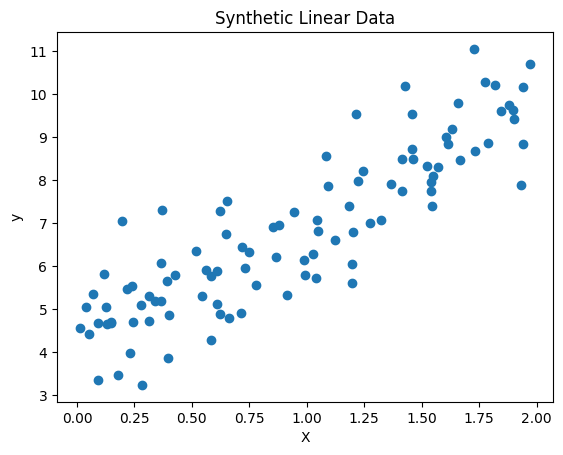

In [7]:
# Generating synthetic data
np.random.seed(42)
X_linear = 2 * np.random.rand(100, 1)
y_linear = 4 + 3 * X_linear + np.random.randn(100, 1)

plt.scatter(X_linear, y_linear)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Linear Data")
plt.show()


The idea behind gradient descent is to update the model parameters (in this case, \( w \) and \( b \)) iteratively to minimize the MSE. The updates are done in the direction of the steepest decrease of the MSE.

For each parameter \( \theta \) (which could be \( w \) or \( b \)), the update rule is:

$ \theta = \theta - \alpha \times \nabla_\theta \text{MSE}(\theta) $

Where:
- $ \alpha $ is the learning rate, a hyperparameter that determines the step size at each iteration.
- $ \nabla_\theta \text{MSE}(\theta) $ is the gradient of the MSE with respect to the parameter $ \theta $.



#### Gradient Descent for Linear Regression

Before implementing gradient descent, let's establish the objective function: the Mean Squared Error (MSE). For \( m \) data points, the MSE is given by:

$$
\text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

Where $ \hat{y}_i $ is the predicted value for the $ i $-th data point, and $ y_i $ is the true value. The predicted value is:

$$
\hat{y}_i = w \cdot x_i + b
$$

To perform gradient descent, we need the gradient of the MSE with respect to the model parameters \( w \) and \( b \). The update rules are:

$$
w = w - \alpha \times \frac{2}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i) x_i
$$

$$
b = b - \alpha \times \frac{2}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)
$$

Where $ \alpha $ is the learning rate.

Take a look how we implement below:

```
    # Predictions
    y_pred = w_current * X + b_current

    # Calculate MSE and store
    mse = compute_mse(y, y_pred)

    # Gradients
    gradient_w = (2/len(X)) * X.T.dot(y_pred - y)
    gradient_b = 2 * (y_pred - y).mean()

    # Update rules
    w_current -= learning_rate * gradient_w[0][0]  
    b_current -= learning_rate * gradient_b

```

In [8]:
mse_history_manual = []
w_history = [np.random.randn()]
b_history = [np.random.randn()]
gradient_w_history = []
gradient_b_history = []

def reset_grad_globals():
    global w_history, b_history, mse_history_manual, gradient_w_history, gradient_b_history

    mse_history_manual = []
    w_history = [np.random.randn()]
    b_history = [np.random.randn()]
    gradient_w_history = []
    gradient_b_history = []

def compute_mse(y_true, y_pred):
    """Compute Mean Squared Error."""
    return ((y_pred - y_true) ** 2).mean()

def manual_gradient_descent_step(X, y, learning_rate):
    global w_history, b_history, mse_history_manual, gradient_w_history, gradient_b_history

    # Current weight and bias
    w_current = w_history[-1]
    b_current = b_history[-1]

    # Predictions
    y_pred = w_current * X + b_current

    # Calculate MSE and store
    mse = compute_mse(y, y_pred)
    mse_history_manual.append(mse)

    # Gradients
    gradient_w = (2 / len(X)) * X.T.dot(y_pred - y)
    gradient_b = 2 * (y_pred - y).mean()

    # Store gradients
    gradient_w_history.append(gradient_w[0][0])
    gradient_b_history.append(gradient_b)

    # Update rules
    w_current -= learning_rate * gradient_w[0][0]
    b_current -= learning_rate * gradient_b

    # Store updated parameters
    w_history.append(w_current)
    b_history.append(b_current)

    # Plot the data vs. linear model and histories in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Data vs. linear model
    axs[0, 0].scatter(X, y, label="Data points")
    axs[0, 0].plot(X, w_current * X + b_current, color="red", label="Current Learned Linear Model")
    axs[0, 0].set_title('Data vs. Linear Model')
    axs[0, 0].set_xlabel('X')
    axs[0, 0].set_ylabel('y')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # If this is the first iteration, only show the data plot
    if len(mse_history_manual) > 1:
        # MSE history
        axs[0, 1].plot(mse_history_manual, 'r')
        axs[0, 1].set_title('MSE History')
        axs[0, 1].set_xlabel('Iterations')
        axs[0, 1].set_ylabel('MSE')

        # Parameter values history
        axs[1, 0].plot(w_history, 'g', label="Weight (w)")
        axs[1, 0].plot(b_history, 'b', label="Bias (b)")
        axs[1, 0].set_title('Parameter Values History')
        axs[1, 0].set_xlabel('Iterations')
        axs[1, 0].set_ylabel('Parameter Value')
        axs[1, 0].legend()

        # Gradients history (combined)
        axs[1, 1].plot(gradient_w_history, 'g', label="Gradient w.r.t Weight (w)")
        axs[1, 1].plot(gradient_b_history, 'b', label="Gradient w.r.t Bias (b)")
        axs[1, 1].set_title('Gradients History')
        axs[1, 1].set_xlabel('Iterations')
        axs[1, 1].set_ylabel('Gradient Value')
        axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


Use this cell to reset gradient descent.

In [9]:
reset_grad_globals()
# Return initial values for confirmation
w_history[-1], b_history[-1]

(-0.2646568332379561, 2.720169166589619)

Use this cell to step through gradient descent. Explore the use of different learning rates.

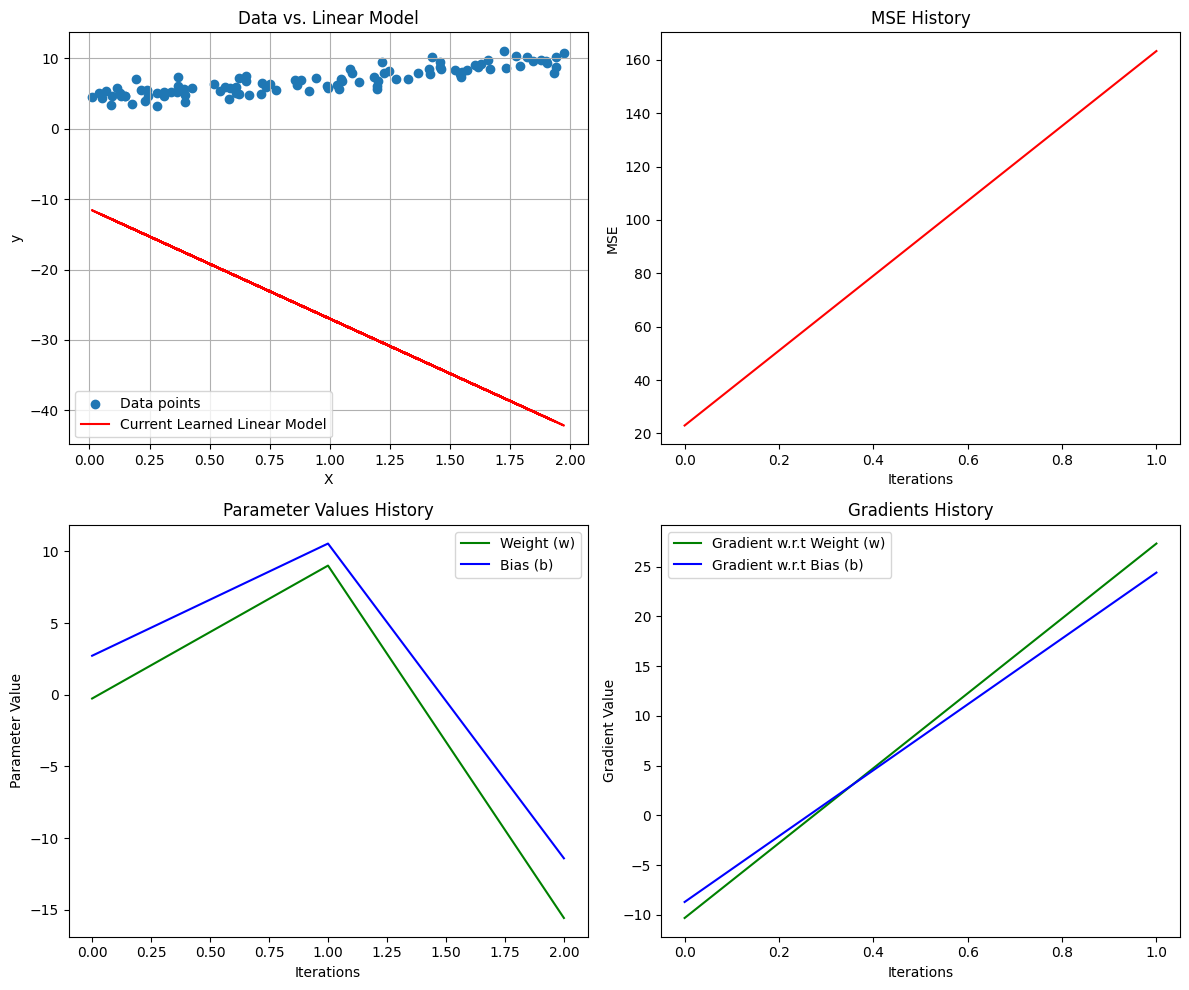

In [11]:
manual_gradient_descent_step(X_linear, y_linear, learning_rate=0.9)

Take a look at how it works on our previous data which was not linear.

In [12]:
reset_grad_globals()

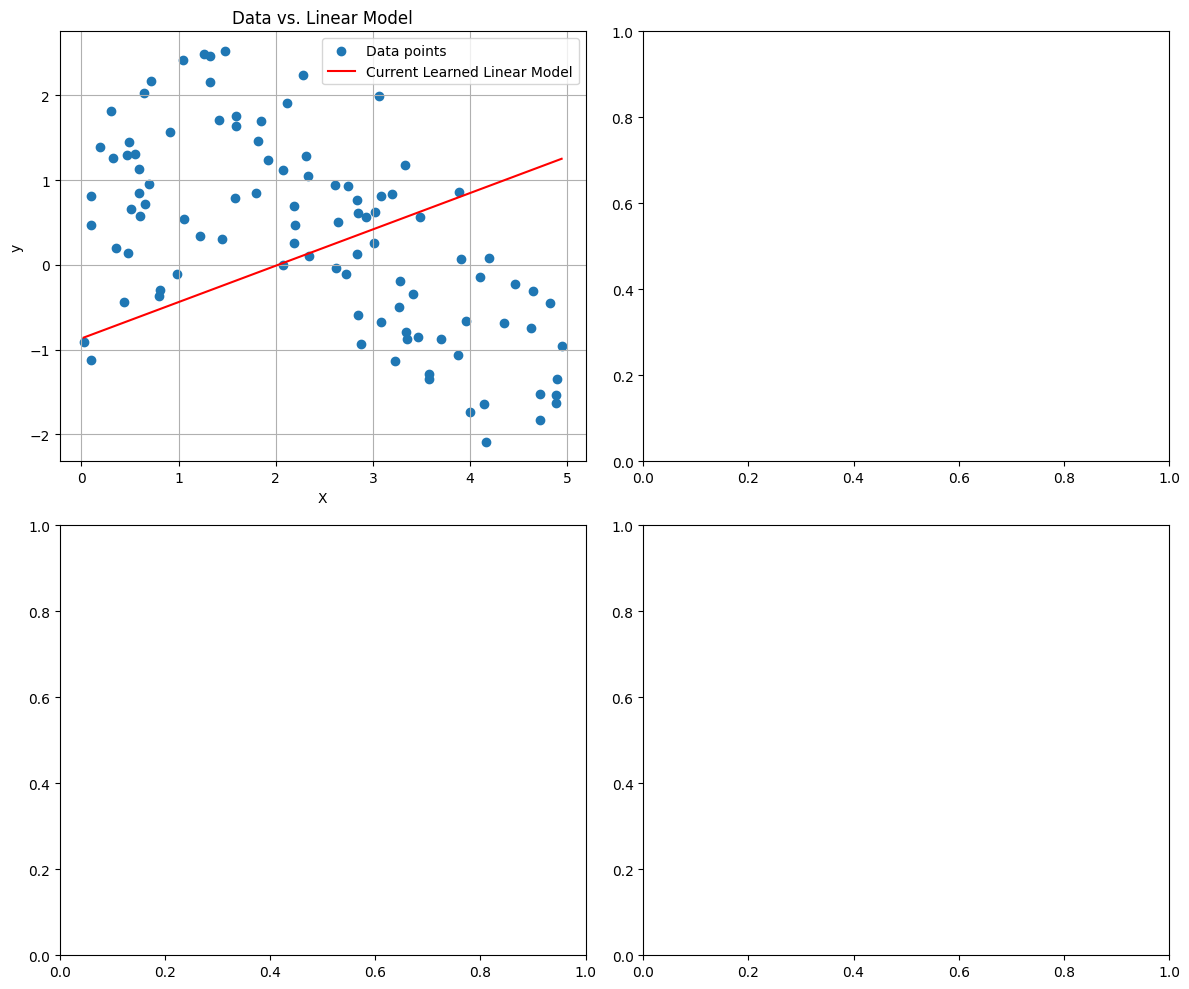

In [13]:
manual_gradient_descent_step(X, y, learning_rate=0.02)